In [190]:
# import relevant libraries
import numpy as np
import pandas as pd
import csv
from scipy.signal import butter, sosfilt
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [191]:
# parse the csv files into arrays
xvals = None
clean_sine_vals = None
noisy_sine_vals = None
with open('../quant_spec_coding/data/xvalsSine.csv', 'r') as xfile, \
    open('../quant_spec_coding/data/cleanSine.csv', 'r') as clean_file, \
    open('../quant_spec_coding/data/noisySine.csv', 'r') as noisy_file:
    xvals = list(csv.reader(xfile))
    clean_sine_vals = list(csv.reader(clean_file))
    noisy_sine_vals = list(csv.reader(noisy_file))
xvals = np.array([x[0] for x in xvals], dtype=float)
clean_sine_vals = np.array([c[0] for c in clean_sine_vals], dtype=float)
noisy_sine_vals = np.array([n[0] for n in noisy_sine_vals], dtype=float)

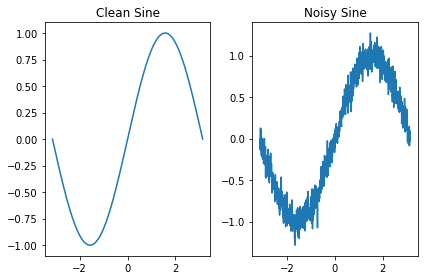

In [192]:
# Plot the clean and noisy sine functions
plt.subplot(1, 2, 1)
plt.plot(xvals, clean_sine_vals, label="Clean sin(x)")
plt.title("Clean Sine")
plt.subplot(1, 2, 2)
plt.plot(xvals, noisy_sine_vals, label="Noisy sin(x)")
plt.title("Noisy Sine")
plt.tight_layout()
plt.show()

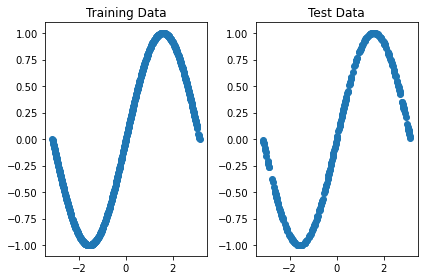

In [193]:
# perform 70-30 train-test split on data
X_train, X_test, y_train, y_test = train_test_split(xvals, clean_sine_vals, train_size=0.7)
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train)
plt.title("Training Data")
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test)
plt.title("Test Data")
plt.tight_layout()
plt.show()

In [194]:
# Generate polynomial features for the OLS regression. We will use a degree 5 polynomial basis
poly_feat = PolynomialFeatures(degree=5)
X_train_poly = poly_feat.fit_transform(X_train.reshape(-1, 1))
X_test_poly = poly_feat.fit_transform(X_test.reshape(-1, 1))

In [195]:
# Build the model using the generated polynomial features
model_ols = sm.OLS(y_train, X_train_poly).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.761e+06
Date:                Tue, 22 Aug 2023   Prob (F-statistic):               0.00
Time:                        00:47:16   Log-Likelihood:                 2822.6
No. Observations:                 700   AIC:                            -5633.
Df Residuals:                     694   BIC:                            -5606.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.601      0.548      -0.000       0.001
x1             0.9881      0.000   2524.869      0.000       0.987       0.989
x2            -0.0001      0.000     -0.596      0.551      -0.001       0.000
x3            -0.1554      0.000   -992.524      0.000      -0.156      -0.155
x4          1.386e-05   2.23e-05      0.620      0.535      -3e-05    5.77e-05
x5             0.0057    1.4e-05    403.331      0.000       0.006       0.006
==============================================================================
Omnibus:                        1.969   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.842
Skew:                          -0.073   Prob(JB):                        0.398
Kurtosis:                       3.205   Cond. No.                         239.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

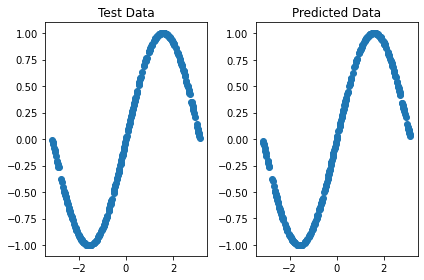

In [196]:
# Plot the predicted data and compare with the test set
y_pred = model_ols.predict(X_test_poly)
plt.subplot(1, 2, 1)
plt.scatter(X_test, y_test)
plt.title("Test Data")
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_pred)
plt.title("Predicted Data")
plt.tight_layout()
plt.show()

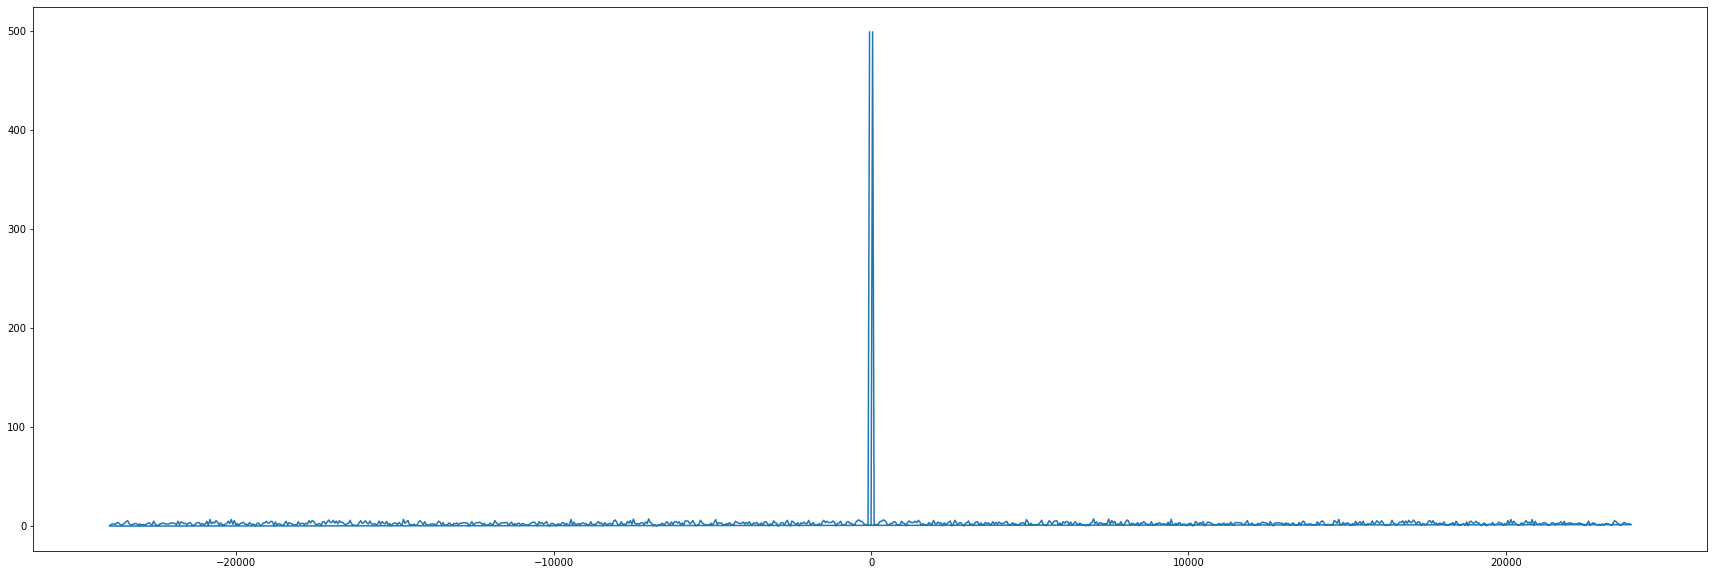

In [197]:
# Plot the Fast Fourier Transform (FFT) to find which frequencies of noise should be filtered out. 
N = len(xvals)
SAMPLE_RATE = 48000 # sampling rate of 48kHz
fft_data = fft(noisy_sine_vals)
fft_xvals = fftfreq(N, 1/SAMPLE_RATE) # x-axis frequency values in Hz
plt.figure(figsize=(30,10))
plt.plot(fft_xvals, np.abs(fft_data))
plt.show()

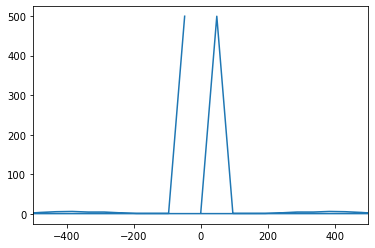

In [198]:
# zoom in on the middle of the plot to get the frequency of the sin wave
plt.xlim(-500, 500)
plt.plot(fft_xvals, np.abs(fft_data))
plt.show()

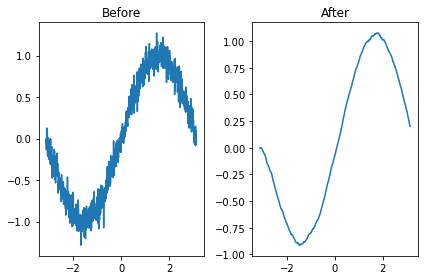

In [199]:
# The primary frequency of the sine wave is 100 Hz. To filter it, we can use a bandpass filter with a center
# frequency fo fc=100Hz and a bandwidth of 200 Hz to account for delay
sos = butter(1, [5, 195], 'bandpass', fs=SAMPLE_RATE, output='sos')
filtered_sine = sosfilt(sos, noisy_sine_vals)
plt.subplot(1, 2, 1)
plt.plot(xvals, noisy_sine_vals)
plt.title("Before")
plt.subplot(1, 2, 2)
plt.plot(xvals, filtered_sine)
plt.title("After")
plt.tight_layout()
plt.show()

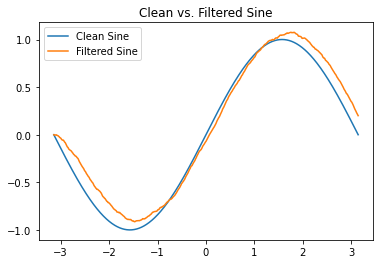

In [200]:
plt.plot(xvals, clean_sine_vals, label="Clean Sine")
plt.plot(xvals, filtered_sine, label="Filtered Sine")
plt.title("Clean vs. Filtered Sine")
plt.legend()
plt.show()

In [201]:
# compute residuals and root-mean squared error from filtered to clean sine
residuals = filtered_sine - clean_sine_vals
RMSE = mean_squared_error(clean_sine_vals, filtered_sine, squared=False)
print("Residuals:\n", residuals)
print("-"*100)
print("RMSE:\n", RMSE)

Residuals:
 [-6.10578076e-04  5.04855057e-03  9.70229074e-03  1.41219698e-02
  2.17820014e-02  2.99029234e-02  3.49720195e-02  4.01764360e-02
  4.82338093e-02  5.51051778e-02  5.80682781e-02  6.17908791e-02
  6.69385013e-02  7.23962416e-02  7.83467726e-02  8.14807148e-02
  8.30527306e-02  8.71262467e-02  9.04994371e-02  9.14147945e-02
  9.53970044e-02  1.00585024e-01  1.04094918e-01  1.07375544e-01
  1.09601669e-01  1.10177636e-01  1.11358686e-01  1.15466178e-01
  1.19550660e-01  1.23911039e-01  1.30845214e-01  1.37151158e-01
  1.41164250e-01  1.42756605e-01  1.42836195e-01  1.43229265e-01
  1.45157390e-01  1.49567232e-01  1.50834104e-01  1.49834321e-01
  1.50756107e-01  1.49531546e-01  1.48098294e-01  1.47819560e-01
  1.47480490e-01  1.49256882e-01  1.53120102e-01  1.55099356e-01
  1.54103587e-01  1.53381823e-01  1.55948638e-01  1.59222953e-01
  1.62428318e-01  1.65653990e-01  1.69917766e-01  1.73765676e-01
  1.77402372e-01  1.81035489e-01  1.82921030e-01  1.85625415e-01
  1.85918240e